## Приложение знакомств

Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

**Задача** – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

## План:
1. Определить цель эксперимента.
2. Определить метрики.
3. Сформулировать гипотезу, определить уровень значимости.
4. Загрузить данные. Проверить на отсутствие пустых значений, определить размеры выборок и их независимость.
5. Выбрать метод сравнения групп. 
6. Получить результаты и проанализировать их. 

### 1. Определить цель эксперимента.   
В условии задачи дано, что целью эксперимента является улучшение качества сервиса. Кажется, что это может быть готовой целью, однако не всё так просто. Давайте вспомним (или узнаем ;)  ), что такое дейтинговые приложения для знакомств. Есть две стороны: пользователь и бизнес. И определение качества сервиса с двух этих сторон будет различаться. Цели у пользователей могут быть разными: найти краткосрочные отношения, долгосрочные отношения, получить флирт, социальные "поглаживания" в виде лайков и т.д. Для простоты определим цель пользователя в приложении: получать как можно больше мэтчей, то есть взаимных лайков от пользователей, чьи анкеты максимально совпадают с запросом пользователя. С точки зрения бизнеса удовлетворить полностью запрос пользователя может стать выстрелом себе в ногу. Для пользователя успех — это найти себе пару в краткие сроки. Для бизнеса успех — это удержание пользователя, если сказать прямо, то цель в том, чтобы пользователь не нашёл себе пару никогда или как можно дольше, но при этом не разочаровался полностью и не удалил приложение. В основном дэйтинговые приложения зарабатывают показами рекламы и подпиской. Важно соблюдать баланс: выдавать достаточное количество анкет и мэтчей, чтобы поддерживать интерес пользователя, но не подбирать очень подходящие для этого анкеты, которые могут поспособствовать оттоку. 
### 2. Определить метрики. 
Так как я выступаю на стороне бизнеса, то и качество нового алгоритма буду оценивать с точки зрения бизнеса. В наших данных нет таймстемпов сессий пользователей, поэтому я не могу посмотреть частоту, время использования приложения, ежедневную активность пользователей, % удержания. Но предположим, что у нас честный тест, и обе группы провели в эксперименте одинаковое количество времени. Если за один период пользователи совершают разное количество действий (в нашем случае просмотров), то это может свидетельствовать о разной степени вовлечённости и интереса к приложению. Я определяю целевой метрикой — количество просмотров, т.е. количество выданных анкет на одного пользователя. Чем больше анкет, тем выше стимул заходить в приложение и проводить там дольше времени, а значит эффективнее наш новый алгоритм. При этом важно не уронить привычную для пользователей долю мэтчей, если в приложении будут только показы, без взаимных лайков, это может понизить замооценку пользователей и разочаровать их. В качестве guardrail-метрики будет выступать количество мэтчей.  
### 3. Сформулировать гипотезу и определить уровень значимости. 
H0 — новый алгоритм не влияет на частоту показов анкет пользователям
H1 — новый алгоритм оказывает влияние на частоту показов анкет пользователям
Алгоритм — это важный параметр продукта, его ухудшение может привести к оттоку пользователей и снижению показателя их удержания, что негативнго повлияет на финансовые показатели. Поэтому я определю жёсткие критерии успешности теста: α = 0.01, мощность 99%.

### 4. Загрузить и проверить данные
В наших данных 1000 уникальных user_id. Пользователи user_id_1 разбиты на две непересекающиеся группы c количеством пользователей 499 (тест) и 501 (контроль). В данных так же отсутствует пересечение между группами пользователей, анкеты которых были показаны в тестовой и контрольной группах. 

In [215]:
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as ss
from scipy.stats import ttest_ind
from scipy.stats import norm
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from urllib.parse import urlencode
import json
%matplotlib inline

In [3]:
public_link = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'
resources = "https://cloud-api.yandex.net/v1/disk/public/resources?"
requests_url = resources + urlencode(dict(public_key=public_link))
r =  requests.get(requests_url)
final_url = r.json()['file']
dating = pd.read_csv(final_url)

In [71]:
dating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [5]:
dating.user_id_1.nunique()

1000

In [6]:
dating.user_id_2.nunique()

1000

In [59]:
test = dating.query('group == 1').user_id_1.to_list()

In [60]:
control = dating.query('group == 0').user_id_1.to_list() 

In [86]:
intersection_t_c = [] #проверка пересечения в тестовой и контрольной группах
for i in test:
    if i in control:
        intersection.append(i)        

In [87]:
len(intersection_t_c)

0

In [63]:
test_2 = dating.query('group == 1').user_id_2.to_list()

In [64]:
control_2 = dating.query('group == 1').user_id_2.to_list()

In [74]:
intersection_c_t2 = [] #встречались ли пользователи, анкеты которых показывали в тестовой группе для контрольной группы
for i in control:
    if i in test_2:
        intersection.append(i)        

In [75]:
len(intersection_c_t2)

0

In [77]:
intersection_t_c2 = [] #встречались ли пользователи, анкеты которых показывали в контрольной группе для тестовой группы
for i in test:
    if i in control_2:
        intersection.append(i)    

In [78]:
len(intersection_t_c2)

0

In [81]:
dating.query('group == 0').user_id_2.nunique()

501

In [82]:
dating.query('group == 1').user_id_2.nunique()

499

In [83]:
dating.query('group == 0').user_id_1.nunique()

501

In [84]:
dating.query('group == 1').user_id_1.nunique()

499

### 5. Выбрать метод сравнения групп.

Визуализация распределений показывает, что они похожи на нормальные. Проверю возможность применения t-теста для сравнения двух средних в выборках:
1. Ранее я проверила, что выборки являются независимыми друг от друга, следовательно, они не коррелируют.
2. Так же нет оснований отклонить предположение, что распределение признаков в каждой выборке соответствует нормальному. 
2. Предположим, что дисперсия в группах равна. P-value 0,32 для f-критерия не позволяет отклонить эту гипотезу, поэтому критерий равенства дисперсий считаю соблюденным.  


Я не вижу препятствий для применения t-теста в качестве инстумента для проведения тестирования. 

In [92]:
ab_test = dating.groupby(['group', 'user_id_1'], as_index=False).user_id_2.count() \
                .rename(columns={'user_id_1': 'user_id', 'user_id_2': 'number_of_profiles_shown'})

<Axes: xlabel='number_of_profiles_shown', ylabel='Count'>

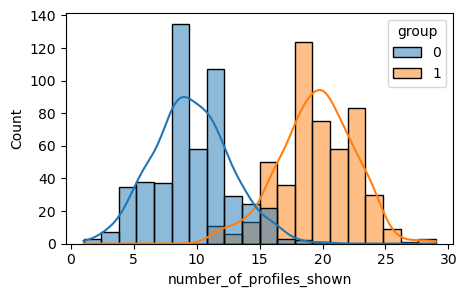

In [130]:
#визуализация распределений количества показов профилей других пользователей
plt.figure(figsize=(5,3))
sns.histplot(data=ab_test, x=ab_test.number_of_profiles_shown, hue=ab_test.group, bins=20, kde=True)

In [136]:
# тест на нормальность распределения
pg.normality(data=ab_test, dv='number_of_profiles_shown', group='group', method='normaltest')

,W,pval,normal
group,,,
0,2.406168,0.300267,True
1,4.262189,0.118707,True


Text(0.5, 1.0, 'test')

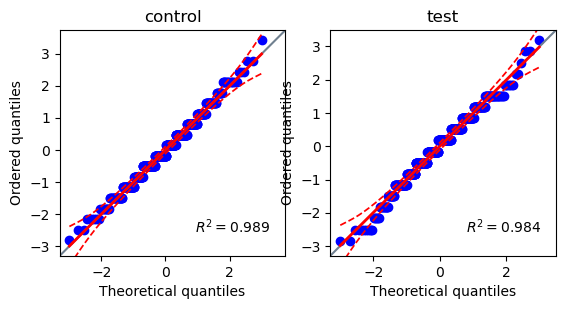

In [163]:
# QQ плот для визуализации нормальности распределений
plt.subplot(1, 2, 1)
pg.qqplot(ab_test.query('group == 0').number_of_profiles_shown)
plt.title("control")
plt.subplot(1, 2, 2)
pg.qqplot(ab_test.query('group == 1').number_of_profiles_shown)
plt.title("test")

<Axes: xlabel='group', ylabel='number_of_profiles_shown'>

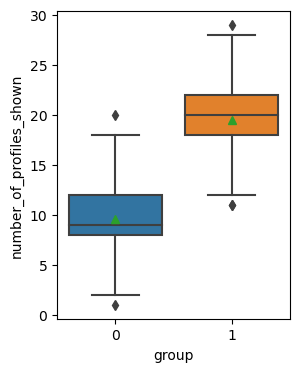

In [238]:
# боксплот, на котором можем увидеть, в каком интервале находится большинство наших значений, медиану и среднее
plt.figure(figsize=(3,4))
sns.boxplot(data=ab_test, x='group', y='number_of_profiles_shown', showmeans=True)

In [236]:
n1 = 501 
n2 = 499
s1 = np.var(ab_test.query('group == 0').number_of_profiles_shown, ddof=1)
s2 = np.var(ab_test.query('group == 1').number_of_profiles_shown, ddof=1) 

In [237]:
f = s1/s2 
dfn = n1-1 
dfd = n2-1
p = 1-ss.f.cdf(f, dfn, dfd) 
print('P-value для равенства дисперсий в группах: {f:.2f}'.format(f=p))

P-value для равенства дисперсий в группах: 0.32


### 6. Получить результаты и проанализировать их.   
Среднее контрольной группы 9.56, с вероятностью 0.99 среднее генеральной совокупности находится в пределах 9.21-9.92.  
Среднее тестовой группы 19.48 с 99% доверительным интервалом 19.14-19.83, доверительные интервалы этих двух групп не пересекаются, что уже свидетельствует о том, что случайно получить выборку с таким средним, как в тестовой группе, маловероятно.  
P-value, полученный в t-тесте, имеет низкое значение. Значит, вероятность получить такое или ещё более выраженное значение среднего равна 1.8942877064043142e-285. Что даёт нам основание отклонить нулевую гипотезу о том, что новый алгоритм не влияет на средние значения количества демонстраций профилей других пользователей.  
С влиянием разобрались, очень вероятно, что оно существует. Давайте посмотрим, какое это влияние.  

Для лучшего понимания и интерпретации нашего теста можем воспользоваться несколькими дополнительными параметрами:  
1. Lift — насколько изменилась метрика теста от метрики контроля, в нашем случае прирост составил 103.69%.
2. Effect Size (размер эффекта) — это стандартизированный прирост, показывает, на какое количество ошибок среднего изменилась метрика, он составил 3.28.
3. Можем ретроспективно оценить минимальный детектируемый эффект (MDE) нашего эксперимента. MDE для выборки в 499 наблюдений, с α = 0.01 и мощностью 99%: 3.97, т.е. изменение на этот показатель уже было бы достаточным, чтобы завершить успешно эксперимент.

Не будем забывать о нашей guardrail-метрике, количестве мэтчей. Нам важно, чтобы количество мэтчей не снизилось, во избежание потери интереса пользовталей к приложению. Доля мэтчей среди всех показов в контрольной групее 19.49%, в тестовой 40.21%. Доля совпадений у пользователей не снизилась, но заметное повышение тоже может дать негативный эффект. При частых мэтчах у пользователей появляется больше шансов найти подходящую пару и перестать использовать приложение. 

### Выводы:
Исходя из полученных результатов, можно сделать вывод о положительном влянии нового алгоритма на метрику показов профилей пользователям. Однако при этом есть влияние на количество мэтчей, что в перспективе может изменить поведение пользователей. Рекомендую провести A/B тест, в котором будет исследование влияния доли мэтчей у пользователей на % удержания пользоватлей. 

In [195]:
m1 = ab_test.query('group == 0').number_of_profiles_shown.mean()
print('Среднее контрольной группы: {f:.2f}'.format(f=m1))

Среднее контрольной группы: 9.56


In [239]:
ci1 = ss.t.interval(confidence=0.99, df=len(ab_test.query('group == 0').number_of_profiles_shown)-1, loc=np.mean(ab_test.query('group == 0').number_of_profiles_shown), scale=ss.sem(ab_test.query('group == 0').number_of_profiles_shown))
print('Доверительный интервал контрольной группы: {f:.2f} - {f1:.2f}'.format(f=ci1[0], f1=ci1[1]))

Доверительный интервал контрольной группы: 9.21 - 9.92


In [241]:
m2 = ab_test.query('group == 1').number_of_profiles_shown.mean()
print('Среднее тестовой группы: {f:.2f}'.format(f=m2))

Среднее тестовой группы: 19.48


In [240]:
ci2= ss.t.interval(confidence=0.99, df=len(ab_test.query('group == 0').number_of_profiles_shown)-1, loc=np.mean(ab_test.query('group == 1').number_of_profiles_shown), scale=ss.sem(ab_test.query('group == 1').number_of_profiles_shown))
print('Доверительный интервал тестовой группы: {f:.2f} - {f1:.2f}'.format(f=ci2[0], f1=ci2[1]))

Доверительный интервал тестовой группы: 19.14 - 19.83


In [243]:
tt = ttest_ind(ab_test.query('group == 0').number_of_profiles_shown, ab_test.query('group == 1').number_of_profiles_shown)
print('T-test. Статистика: {f:.2f}. P-value: {f1:.3f}'.format(f=tt[0], f1=tt[1]))

T-test. Статистика: -51.85. P-value: 0.000


In [242]:
tt

Ttest_indResult(statistic=-51.85383774946492, pvalue=1.8942877064043142e-285)

In [210]:
lift = (ab_test.query('group == 1').number_of_profiles_shown.mean()-ab_test.query('group == 0').number_of_profiles_shown.mean())/ab_test.query('group == 0').number_of_profiles_shown.mean()*100
print('Прирост метрики в тестовой группе по сравнению с контрольной (lift): {f:.2f}%'.format(f=lift))

Прирост метрики в тестовой группе по сравнению с контрольной (lift): 103.69%


In [211]:
s_pooled = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

effect_size = (m2-m1)/s_pooled
print('Размер эффекта: {f:.2f}'.format(f=effect_size))

Размер эффекта: 3.28


In [223]:
def estimate_effect_size(n, sd, alpha=0.01, power=0.99):
    M = (norm.ppf(q=1-alpha/2) + norm.ppf(q=power))**2
    return np.sqrt(2 * M * sd**2 / n) / sd

n = 499
sd = ab_test.query('group == 0').number_of_profiles_shown.std()

mde = estimate_effect_size(sd, n) 
print('MDE для выборки в 499 наблюдений, с α = 0.01 и мощностью 99%: {f:.2f}'.format(f=mde))

MDE для выборки в 499 наблюдений, с α = 0.01 и мощностью 99%: 3.97


In [244]:
dating

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [250]:
matches = dating.groupby('group').agg({'user_id_2': 'count', 'is_match': 'sum'})

In [255]:
matches['proportion,%'] = round(matches.is_match / matches.user_id_2 * 100, 2)

In [256]:
matches

,user_id_2,is_match,"proportion,%"
group,,,
0,4792,934,19.49
1,9722,3909,40.21
